# Libraries

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import copy
import matplotlib.pyplot as plt
import time
import os

# Configuration

In [34]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPOCHS_BASELINE = 20
EPOCHS_FINETUNE = 20
LEARNING_RATE = 0.01
print(f"Running on: {DEVICE}")

Running on: cuda


# Model

In [35]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [36]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Modified for CIFAR-10: kernel_size 3x3, stride 1, no maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Data

In [37]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Helper Functions

In [38]:
def train(model, loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.3f} | Acc: {100.*correct/total:.2f}%")

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    return acc

def get_model_size_mb(model):
    """Calculate crude model size based on parameters count (assuming fp32)"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

# Custom Layer for Clustered Weights (Fine-Tuning Phase)

In [39]:
# --- 4. Custom Layer for Clustered Weights (Fine-Tuning Phase) ---
class ClusteredConv2d(nn.Module):
    def __init__(self, original_conv, centroids, labels):
        super(ClusteredConv2d, self).__init__()

        # Metadata
        self.in_channels = original_conv.in_channels
        self.out_channels = original_conv.out_channels
        self.kernel_size = original_conv.kernel_size
        self.stride = original_conv.stride
        self.padding = original_conv.padding
        self.dilation = original_conv.dilation
        self.groups = original_conv.groups
        self.bias = nn.Parameter(original_conv.bias) if original_conv.bias is not None else None

        # Compression Logic
        # Centroids is the look-up table (Trainable Parameter)
        self.centroids = nn.Parameter(torch.tensor(centroids, dtype=torch.float32))

        # Indices map every weight to a centroid (Frozen Buffer - not trainable)
        # We use int32 or int16, but PyTorch buffers are usually tensors
        self.register_buffer('weight_indices', torch.tensor(labels, dtype=torch.long))

        self.weight_shape = original_conv.weight.shape

    def forward(self, x):
        # 1. Reconstruct weights from the lookup table
        # self.centroids[self.weight_indices] fetches the float value for every index
        reconstructed_weight = self.centroids[self.weight_indices].view(self.weight_shape)


        return F.conv2d(x, reconstructed_weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

def replace_layers_with_clustered(model, clustered_layers_dict):
    """
    Recursively replace Conv2d layers with ClusteredConv2d.
    clustered_layers_dict maps layer names to (centroids, labels).
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            # Check if we have clustering data for this layer (we skip 1x1 shortcuts sometimes or first layer if desired)
            # For this code, we assume we cluster all convs if they are in the dict
            # We need a way to track the full name, simplistic approach here:
            pass # Replacement happens in the main loop per layer reference

# Clustering Algorithms

In [40]:
def apply_kmeans(weights_np, k):
    """
    Weights: Flattened numpy array of weights
    Returns: centroids, labels
    """
    # Initialize KMeans
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)
    labels = kmeans.fit_predict(weights_np.reshape(-1, 1))
    centroids = kmeans.cluster_centers_.flatten()
    return centroids, labels

def apply_gmm(weights_np, n_components):
    """
    Gaussian Mixture Models
    Returns: means (centroids), labels (predicted component)
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(weights_np.reshape(-1, 1))
    labels = gmm.predict(weights_np.reshape(-1, 1))
    centroids = gmm.means_.flatten()
    return centroids, labels

def apply_dbscan(weights_np, eps):
    """
    DBSCAN is tricky for fixed compression because it produces variable clusters + noise (-1).
    Strategy:
    1. Run DBSCAN.
    2. Calculate centroids for valid clusters.
    3. Map noise (-1) to the nearest valid centroid (or 0).
    """
    # We must downsample for DBSCAN as it's O(N^2) and will crash on millions of weights
    # We take a representative sample to find clusters, then predict for all (using nearest neighbor)

    # Sampling 10% or max 20k points to find core clusters
    sample_size = min(len(weights_np), 20000)
    sample_indices = np.random.choice(len(weights_np), sample_size, replace=False)
    sample_data = weights_np[sample_indices].reshape(-1, 1)

    db = DBSCAN(eps=eps, min_samples=5)
    db.fit(sample_data)

    # Calculate centroids of the found clusters
    unique_labels = set(db.labels_)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    if len(unique_labels) == 0:
        # Fallback if DBSCAN finds nothing (eps too small) -> treat as 1 cluster (mean)
        return np.array([np.mean(weights_np)]), np.zeros(len(weights_np), dtype=int)

    centroids = []
    for label in unique_labels:
        cluster_points = sample_data[db.labels_ == label]
        centroids.append(np.mean(cluster_points))
    centroids = np.array(centroids)

    # Now assign ALL original weights to the nearest centroid (Simulating predict)
    # This acts like a quantization based on DBSCAN-discovered densities
    # Efficient way: broadcast subtraction
    # weights: (N,), centroids: (K,)
    # Distance matrix: (N, K) - Careful with memory here, do it in chunks if needed
    # For Colab safety, we just use a simple loop or broadcasting if K is small

    if len(centroids) > 256:
        print(f"Warning: DBSCAN found {len(centroids)} clusters.")

    # Assign all weights to nearest centroid found by DBSCAN
    # Reshape for broadcasting: weights (N, 1), centroids (1, K)
    # This might OOM if N is large. Let's do a simple chunking or just use K-Means assign logic.
    from sklearn.metrics import pairwise_distances_argmin

    # Chunking to prevent OOM
    labels = []
    chunk_size = 100000
    for i in range(0, len(weights_np), chunk_size):
        chunk = weights_np[i:i+chunk_size].reshape(-1, 1)
        chunk_labels = pairwise_distances_argmin(chunk, centroids.reshape(-1, 1))
        labels.append(chunk_labels)

    labels = np.concatenate(labels)

    return centroids, labels

# Baseline Training & Finetuning

## Install and Configure WandB
Install the wandb library and perform initial login.


In [41]:
!pip install wandb

In [42]:
import wandb
wandb.login()

True

In [43]:
import warnings
warnings.filterwarnings("ignore")
import wandb
wandb.login()

True

## Update Training Function

### Subtask:
Modify the training loop to log metrics to Weights & Biases.


**Reasoning**:
I will redefine the `train` function to include `wandb.log` calls at the end of each epoch, recording 'epoch', 'train_loss', and 'train_accuracy' as requested.



In [44]:
def train(model, loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        epoch_loss = running_loss / len(loader)
        epoch_acc = 100. * correct / total

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.3f} | Acc: {epoch_acc:.2f}%")

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": epoch_loss,
            "train_accuracy": epoch_acc
        })

# Experiments/Main Run

In [45]:
import wandb
try:
    wandb.finish()
except Exception as e:
    print(f"WandB finish failed (no active run or other error): {e}")

**Reasoning**:
I will generate the main execution block that force-retrains the baseline model and runs the clustering experiments (K-Means, GMM, DBSCAN) with WandB logging, ensuring all results are captured.



In [46]:
# --- Phase 1: Baseline Training with WandB ---
print("--- Phase 1: Baseline Training ---")
wandb.init(project="resnet-compression", name="baseline", reinit=True)

# Initialize model from scratch
baseline_model = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)

# Force training (do not load existing weights)
train(baseline_model, trainloader, optimizer, criterion, EPOCHS_BASELINE)

# Evaluate
baseline_acc = evaluate(baseline_model, testloader)
baseline_size_mb = get_model_size_mb(baseline_model)
print(f"Baseline Accuracy: {baseline_acc:.2f}% | Size: {baseline_size_mb:.2f} MB")

# Log to WandB
wandb.log({
    "Test Accuracy": baseline_acc,
    "Model Size (MB)": baseline_size_mb
})

# Save and finish
torch.save(baseline_model.state_dict(), 'baseline_resnet18.pth')
wandb.finish()

# --- Phase 2: Clustering Experiments with WandB ---

def run_experiment(method_name, param_name, param_val, cluster_func):
    print(f"\n--- Running {method_name} ({param_name}={param_val}) ---")

    # Initialize WandB run for this experiment
    config = {
        "method": method_name,
        param_name: param_val,
        "epochs_finetune": EPOCHS_FINETUNE
    }
    run_name = f"{method_name}_{param_val}"
    wandb.init(project="resnet-compression", name=run_name, config=config, reinit=True)

    # Clone model and load baseline weights
    compressed_model = ResNet18().to(DEVICE)
    compressed_model.load_state_dict(torch.load('baseline_resnet18.pth'))

    total_original_bits = 0
    total_compressed_bits = 0
    modules_to_replace = []

    # 1. Clustering & Metric Calculation
    for name, module in compressed_model.named_modules():
        if isinstance(module, nn.Conv2d):
            weights = module.weight.data.cpu().numpy().flatten()

            # Apply Clustering
            try:
                centroids, labels = cluster_func(weights, param_val)
            except Exception as e:
                print(f"Clustering failed for {name}: {e}")
                continue

            # Create Clustered Layer
            clustered_layer = ClusteredConv2d(module, centroids, labels)
            modules_to_replace.append((name, clustered_layer))

            # Compression Metrics
            n_weights = len(weights)
            n_centroids = len(centroids)
            total_original_bits += n_weights * 32

            # Ensure valid log calculation
            n_centroids = max(1, n_centroids)
            bits_per_index = np.ceil(np.log2(n_centroids)) if n_centroids > 1 else 1
            total_compressed_bits += (n_centroids * 32) + (n_weights * bits_per_index)

    # Replace layers
    for name, new_layer in modules_to_replace:
        sub_module = compressed_model
        tokens = name.split('.')
        for token in tokens[:-1]:
            sub_module = getattr(sub_module, token)
        setattr(sub_module, tokens[-1], new_layer.to(DEVICE))

    # 2. Fine-Tuning
    print("Fine-tuning centroids...")
    ft_optimizer = optim.SGD(compressed_model.parameters(), lr=0.001, momentum=0.9)
    train(compressed_model, trainloader, ft_optimizer, criterion, EPOCHS_FINETUNE)

    # 3. Evaluation
    acc = evaluate(compressed_model, testloader)

    # Calculate Size & Ratio
    comp_ratio = total_original_bits / total_compressed_bits if total_compressed_bits > 0 else 0
    final_size_mb = (total_compressed_bits / 8) / (1024**2)
    # Add non-conv params estimation
    non_conv_size = baseline_size_mb - (total_original_bits/8/1024**2)
    final_size_mb += non_conv_size

    print(f"Result: Acc: {acc:.2f}% | Ratio: {comp_ratio:.2f}x | Size: {final_size_mb:.2f} MB")

    # Log to WandB
    wandb.log({
        "Test Accuracy": acc,
        "Compression Ratio": comp_ratio,
        "Model Size (MB)": final_size_mb
    })
    wandb.finish()

    return {
        "Method": method_name,
        "Param": param_val,
        "Accuracy": acc,
        "Compression Ratio": comp_ratio,
        "Size (MB)": final_size_mb
    }

# --- Run Configurations ---
results = []

# 1. K-Means
for k in [16, 32, 128]:
    res = run_experiment("K-Means", "k", k, apply_kmeans)
    results.append(res)

# 2. GMM
for n in [16, 32]:
    res = run_experiment("GMM", "Components", n, apply_gmm)
    results.append(res)

# 3. DBSCAN
for eps in [0.1, 0.2]:
    res = run_experiment("DBSCAN", "Eps", eps, apply_dbscan)
    results.append(res)

print("\n--- Final Summary ---")
for r in results:
    print(r)

--- Phase 1: Baseline Training ---


Epoch 1/20 | Loss: 1.405 | Acc: 48.64%
Epoch 2/20 | Loss: 0.906 | Acc: 67.83%
Epoch 3/20 | Loss: 0.697 | Acc: 75.61%
Epoch 4/20 | Loss: 0.585 | Acc: 79.76%
Epoch 5/20 | Loss: 0.511 | Acc: 82.25%
Epoch 6/20 | Loss: 0.458 | Acc: 84.19%
Epoch 7/20 | Loss: 0.414 | Acc: 85.53%
Epoch 8/20 | Loss: 0.379 | Acc: 86.87%
Epoch 9/20 | Loss: 0.347 | Acc: 87.96%
Epoch 10/20 | Loss: 0.325 | Acc: 88.62%
Epoch 11/20 | Loss: 0.303 | Acc: 89.41%
Epoch 12/20 | Loss: 0.286 | Acc: 90.08%
Epoch 13/20 | Loss: 0.265 | Acc: 90.79%
Epoch 14/20 | Loss: 0.251 | Acc: 91.23%
Epoch 15/20 | Loss: 0.237 | Acc: 91.76%
Epoch 16/20 | Loss: 0.224 | Acc: 92.16%
Epoch 17/20 | Loss: 0.213 | Acc: 92.51%
Epoch 18/20 | Loss: 0.201 | Acc: 92.97%
Epoch 19/20 | Loss: 0.187 | Acc: 93.52%
Epoch 20/20 | Loss: 0.181 | Acc: 93.56%
Baseline Accuracy: 88.14% | Size: 42.66 MB


Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇████████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Model Size (MB),42.66206
Test Accuracy,88.14
epoch,20
train_accuracy,93.56
train_loss,0.18067



--- Running K-Means (k=16) ---


Fine-tuning centroids...
Epoch 1/20 | Loss: 2.297 | Acc: 11.86%
Epoch 2/20 | Loss: 2.225 | Acc: 16.30%
Epoch 3/20 | Loss: 2.164 | Acc: 18.88%
Epoch 4/20 | Loss: 2.138 | Acc: 19.81%
Epoch 5/20 | Loss: 2.114 | Acc: 21.10%
Epoch 6/20 | Loss: 2.093 | Acc: 22.18%
Epoch 7/20 | Loss: 2.078 | Acc: 23.01%
Epoch 8/20 | Loss: 2.062 | Acc: 23.51%
Epoch 9/20 | Loss: 2.052 | Acc: 23.95%
Epoch 10/20 | Loss: 2.042 | Acc: 24.46%
Epoch 11/20 | Loss: 2.028 | Acc: 25.03%
Epoch 12/20 | Loss: 2.022 | Acc: 25.22%
Epoch 13/20 | Loss: 2.009 | Acc: 25.80%
Epoch 14/20 | Loss: 2.002 | Acc: 25.81%
Epoch 15/20 | Loss: 1.996 | Acc: 26.50%
Epoch 16/20 | Loss: 1.989 | Acc: 26.44%
Epoch 17/20 | Loss: 1.981 | Acc: 26.85%
Epoch 18/20 | Loss: 1.979 | Acc: 26.97%
Epoch 19/20 | Loss: 1.968 | Acc: 27.35%
Epoch 20/20 | Loss: 1.964 | Acc: 27.35%
Result: Acc: 28.06% | Ratio: 8.00x | Size: 5.42 MB


Compression Ratio,▁
Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Compression Ratio,7.99817
Model Size (MB),5.41532
Test Accuracy,28.06
epoch,20
train_accuracy,27.354



--- Running K-Means (k=32) ---


Fine-tuning centroids...
Epoch 1/20 | Loss: 2.174 | Acc: 19.01%
Epoch 2/20 | Loss: 2.116 | Acc: 21.40%
Epoch 3/20 | Loss: 2.079 | Acc: 22.72%
Epoch 4/20 | Loss: 2.052 | Acc: 23.64%
Epoch 5/20 | Loss: 2.026 | Acc: 24.18%
Epoch 6/20 | Loss: 2.046 | Acc: 23.29%
Epoch 7/20 | Loss: 2.047 | Acc: 23.37%
Epoch 8/20 | Loss: 2.031 | Acc: 24.41%
Epoch 9/20 | Loss: 2.012 | Acc: 25.24%
Epoch 10/20 | Loss: 2.001 | Acc: 25.68%
Epoch 11/20 | Loss: 1.982 | Acc: 26.24%
Epoch 12/20 | Loss: 1.962 | Acc: 26.79%
Epoch 13/20 | Loss: 1.965 | Acc: 26.60%
Epoch 14/20 | Loss: 1.952 | Acc: 27.49%
Epoch 15/20 | Loss: 1.930 | Acc: 27.94%
Epoch 16/20 | Loss: 1.917 | Acc: 28.17%
Epoch 17/20 | Loss: 1.905 | Acc: 28.89%
Epoch 18/20 | Loss: 1.895 | Acc: 29.27%
Epoch 19/20 | Loss: 1.875 | Acc: 29.79%
Epoch 20/20 | Loss: 1.849 | Acc: 30.99%
Result: Acc: 25.62% | Ratio: 6.40x | Size: 6.75 MB


Compression Ratio,▁
Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▃▄▄▅▅▅▆▅▆▆▆▇▇▇█
train_loss,█▇▆▅▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▁
Compression Ratio,6.39765
Model Size (MB),6.74683
Test Accuracy,25.62
epoch,20
train_accuracy,30.994



--- Running K-Means (k=128) ---


Fine-tuning centroids...
Epoch 1/20 | Loss: 1.951 | Acc: 28.66%
Epoch 2/20 | Loss: 1.824 | Acc: 31.40%
Epoch 3/20 | Loss: 1.733 | Acc: 35.43%
Epoch 4/20 | Loss: 1.680 | Acc: 37.59%
Epoch 5/20 | Loss: 1.647 | Acc: 39.46%
Epoch 6/20 | Loss: 1.616 | Acc: 40.69%
Epoch 7/20 | Loss: 1.583 | Acc: 42.18%
Epoch 8/20 | Loss: 1.567 | Acc: 42.67%
Epoch 9/20 | Loss: 1.543 | Acc: 43.90%
Epoch 10/20 | Loss: 1.515 | Acc: 44.99%
Epoch 11/20 | Loss: 1.492 | Acc: 45.71%
Epoch 12/20 | Loss: 1.475 | Acc: 46.02%
Epoch 13/20 | Loss: 1.452 | Acc: 47.20%
Epoch 14/20 | Loss: 1.440 | Acc: 47.74%
Epoch 15/20 | Loss: 1.415 | Acc: 48.53%
Epoch 16/20 | Loss: 1.403 | Acc: 48.65%
Epoch 17/20 | Loss: 1.389 | Acc: 49.28%
Epoch 18/20 | Loss: 1.377 | Acc: 49.88%
Epoch 19/20 | Loss: 1.362 | Acc: 50.38%
Epoch 20/20 | Loss: 1.353 | Acc: 50.85%
Result: Acc: 34.18% | Ratio: 4.57x | Size: 9.41 MB


Compression Ratio,▁
Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█▇▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
Compression Ratio,4.56664
Model Size (MB),9.41472
Test Accuracy,34.18
epoch,20
train_accuracy,50.846



--- Running GMM (Components=16) ---


Fine-tuning centroids...
Epoch 1/20 | Loss: 2.254 | Acc: 14.21%
Epoch 2/20 | Loss: 2.213 | Acc: 16.99%
Epoch 3/20 | Loss: 2.221 | Acc: 16.24%
Epoch 4/20 | Loss: 2.188 | Acc: 17.71%
Epoch 5/20 | Loss: 2.173 | Acc: 17.88%
Epoch 6/20 | Loss: 2.165 | Acc: 18.31%
Epoch 7/20 | Loss: 2.152 | Acc: 18.43%
Epoch 8/20 | Loss: 2.147 | Acc: 18.55%
Epoch 9/20 | Loss: 2.137 | Acc: 18.58%
Epoch 10/20 | Loss: 2.131 | Acc: 18.89%
Epoch 11/20 | Loss: 2.122 | Acc: 18.94%
Epoch 12/20 | Loss: 2.121 | Acc: 19.00%
Epoch 13/20 | Loss: 2.119 | Acc: 18.94%
Epoch 14/20 | Loss: 2.113 | Acc: 19.30%
Epoch 15/20 | Loss: 2.104 | Acc: 19.48%
Epoch 16/20 | Loss: 2.101 | Acc: 19.66%
Epoch 17/20 | Loss: 2.098 | Acc: 19.92%
Epoch 18/20 | Loss: 2.097 | Acc: 19.85%
Epoch 19/20 | Loss: 2.094 | Acc: 19.55%
Epoch 20/20 | Loss: 2.090 | Acc: 20.06%
Result: Acc: 20.00% | Ratio: 8.00x | Size: 5.42 MB


Compression Ratio,▁
Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▃▅▅▆▆▆▆▇▇▇▇▇▇███▇█
train_loss,█▆▇▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
Compression Ratio,7.99817
Model Size (MB),5.41532
Test Accuracy,20
epoch,20
train_accuracy,20.058



--- Running GMM (Components=32) ---


Fine-tuning centroids...
Epoch 1/20 | Loss: 2.274 | Acc: 12.32%
Epoch 2/20 | Loss: 2.246 | Acc: 14.41%
Epoch 3/20 | Loss: 2.194 | Acc: 16.54%
Epoch 4/20 | Loss: 2.161 | Acc: 17.61%
Epoch 5/20 | Loss: 2.131 | Acc: 18.27%
Epoch 6/20 | Loss: 2.135 | Acc: 18.53%
Epoch 7/20 | Loss: 2.123 | Acc: 18.74%
Epoch 8/20 | Loss: 2.114 | Acc: 18.93%
Epoch 9/20 | Loss: 2.096 | Acc: 18.82%
Epoch 10/20 | Loss: 2.082 | Acc: 19.37%
Epoch 11/20 | Loss: 2.072 | Acc: 19.17%
Epoch 12/20 | Loss: 2.063 | Acc: 19.47%
Epoch 13/20 | Loss: 2.071 | Acc: 19.39%
Epoch 14/20 | Loss: 2.036 | Acc: 19.99%
Epoch 15/20 | Loss: 2.053 | Acc: 19.79%
Epoch 16/20 | Loss: 2.024 | Acc: 20.08%
Epoch 17/20 | Loss: 2.025 | Acc: 20.17%
Epoch 18/20 | Loss: 2.008 | Acc: 20.31%
Epoch 19/20 | Loss: 1.996 | Acc: 20.64%
Epoch 20/20 | Loss: 1.987 | Acc: 20.64%
Result: Acc: 15.42% | Ratio: 6.40x | Size: 6.75 MB


Compression Ratio,▁
Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▅▅▆▆▆▇▆▇▇▇▇▇▇█████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▃▂▂▂▁▁
Compression Ratio,6.39765
Model Size (MB),6.74683
Test Accuracy,15.42
epoch,20
train_accuracy,20.638



--- Running DBSCAN (Eps=0.1) ---


Fine-tuning centroids...
Epoch 1/20 | Loss: 2.306 | Acc: 11.41%
Epoch 2/20 | Loss: 2.294 | Acc: 12.51%
Epoch 3/20 | Loss: 2.288 | Acc: 13.69%
Epoch 4/20 | Loss: 2.286 | Acc: 13.76%
Epoch 5/20 | Loss: 2.285 | Acc: 13.55%
Epoch 6/20 | Loss: 2.279 | Acc: 14.07%
Epoch 7/20 | Loss: 2.278 | Acc: 13.94%
Epoch 8/20 | Loss: 2.277 | Acc: 14.15%
Epoch 9/20 | Loss: 2.277 | Acc: 14.16%
Epoch 10/20 | Loss: 2.309 | Acc: 11.06%
Epoch 11/20 | Loss: 2.313 | Acc: 10.02%
Epoch 12/20 | Loss: 2.309 | Acc: 10.33%
Epoch 13/20 | Loss: 2.307 | Acc: 10.83%
Epoch 14/20 | Loss: 2.304 | Acc: 11.21%
Epoch 15/20 | Loss: 2.303 | Acc: 10.92%
Epoch 16/20 | Loss: 2.301 | Acc: 11.16%
Epoch 17/20 | Loss: 2.301 | Acc: 11.18%
Epoch 18/20 | Loss: 2.300 | Acc: 11.20%
Epoch 19/20 | Loss: 2.305 | Acc: 10.55%
Epoch 20/20 | Loss: 2.308 | Acc: 10.11%
Result: Acc: 9.80% | Ratio: 32.00x | Size: 1.42 MB


Compression Ratio,▁
Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▃▅▇▇▇████▃▁▂▂▃▃▃▃▃▂▁
train_loss,▇▄▃▃▃▂▁▁▁▇█▇▇▆▆▆▆▆▇▇
Compression Ratio,31.99816
Model Size (MB),1.42332
Test Accuracy,9.8
epoch,20
train_accuracy,10.108



--- Running DBSCAN (Eps=0.2) ---


Fine-tuning centroids...
Epoch 1/20 | Loss: 2.306 | Acc: 11.28%
Epoch 2/20 | Loss: 2.297 | Acc: 12.62%
Epoch 3/20 | Loss: 2.295 | Acc: 12.55%
Epoch 4/20 | Loss: 2.293 | Acc: 12.55%
Epoch 5/20 | Loss: 2.291 | Acc: 12.79%
Epoch 6/20 | Loss: 2.290 | Acc: 12.82%
Epoch 7/20 | Loss: 2.289 | Acc: 12.74%
Epoch 8/20 | Loss: 2.287 | Acc: 12.92%
Epoch 9/20 | Loss: 2.286 | Acc: 13.05%
Epoch 10/20 | Loss: 2.286 | Acc: 12.90%
Epoch 11/20 | Loss: 2.285 | Acc: 12.90%
Epoch 12/20 | Loss: 2.285 | Acc: 12.95%
Epoch 13/20 | Loss: 2.283 | Acc: 13.08%
Epoch 14/20 | Loss: 2.284 | Acc: 12.97%
Epoch 15/20 | Loss: 2.283 | Acc: 13.10%
Epoch 16/20 | Loss: 2.282 | Acc: 13.23%
Epoch 17/20 | Loss: 2.283 | Acc: 13.19%
Epoch 18/20 | Loss: 2.281 | Acc: 13.01%
Epoch 19/20 | Loss: 2.282 | Acc: 13.24%
Epoch 20/20 | Loss: 2.282 | Acc: 13.38%
Result: Acc: 12.56% | Ratio: 32.00x | Size: 1.42 MB


Compression Ratio,▁
Model Size (MB),▁
Test Accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▅▅▆▆▆▆▇▆▆▇▇▇▇█▇▇██
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁
Compression Ratio,31.99816
Model Size (MB),1.42332
Test Accuracy,12.56
epoch,20
train_accuracy,13.378



--- Final Summary ---
{'Method': 'K-Means', 'Param': 16, 'Accuracy': 28.06, 'Compression Ratio': np.float64(7.998165169177136), 'Size (MB)': np.float64(5.415321350097656)}
{'Method': 'K-Means', 'Param': 32, 'Accuracy': 25.62, 'Compression Ratio': np.float64(6.397651739696262), 'Size (MB)': np.float64(6.746826171875)}
{'Method': 'K-Means', 'Param': 128, 'Accuracy': 34.18, 'Compression Ratio': np.float64(4.566639466828611), 'Size (MB)': np.float64(9.414718627929688)}
{'Method': 'GMM', 'Param': 16, 'Accuracy': 20.0, 'Compression Ratio': np.float64(7.998165169177136), 'Size (MB)': np.float64(5.415321350097656)}
{'Method': 'GMM', 'Param': 32, 'Accuracy': 15.42, 'Compression Ratio': np.float64(6.397651739696262), 'Size (MB)': np.float64(6.746826171875)}
{'Method': 'DBSCAN', 'Param': 0.1, 'Accuracy': 9.8, 'Compression Ratio': 31.998164853503695, 'Size (MB)': 1.4233245849609375}
{'Method': 'DBSCAN', 'Param': 0.2, 'Accuracy': 12.56, 'Compression Ratio': 31.998164853503695, 'Size (MB)': 1.42332

## Visualize and Log Plots

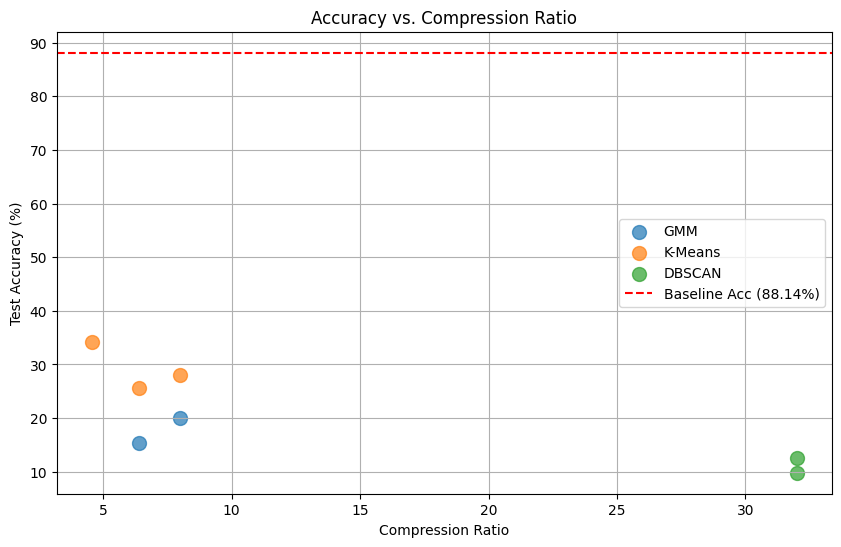

In [47]:
# Initialize summary run
wandb.init(project="resnet-compression", name="summary_analysis", reinit=True)

# Prepare data for plotting
methods = list(set([r['Method'] for r in results]))
plt.figure(figsize=(10, 6))

# Plot each method
for method in methods:
    # Extract points for this method
    x = [r['Compression Ratio'] for r in results if r['Method'] == method]
    y = [r['Accuracy'] for r in results if r['Method'] == method]

    plt.scatter(x, y, label=method, s=100, alpha=0.7)

# Add Baseline Line
plt.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline Acc ({baseline_acc:.2f}%)')

# Labels and Title
plt.xlabel('Compression Ratio')
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy vs. Compression Ratio')
plt.legend()
plt.grid(True)

# Log plot to WandB
wandb.log({"Accuracy vs Compression": wandb.Image(plt)})

# Show plot locally
plt.show()

# Finish run
wandb.finish()

## Summary:

### Data Analysis Key Findings

*   **Baseline Performance**: The ResNet18 model trained from scratch achieved a test accuracy of **88.14%** with a total model size of **42.66 MB**.
*   **K-Means Performance**: This method provided the best balance among the tested compression techniques, though with significant accuracy loss compared to the baseline.
    *   Using $k=128$ yielded the highest accuracy of **34.18%** with a compression ratio of **4.57x**.
    *   Lower $k$ values (16 and 32) resulted in higher compression (up to **8.00x**) but dropped accuracy to **28.06%** and **25.62%** respectively.
*   **GMM Performance**: Gaussian Mixture Models underperformed K-Means, achieving accuracies between **15.42%** and **20.00%**.
*   **DBSCAN Failure**: The DBSCAN method resulted in model collapse. While it achieved a high compression ratio of **32.00x** (1.42 MB), the accuracy plummeted to near-random levels (**~9.8% - 12.6%**), suggesting the parameters (epsilon 0.1/0.2) were too aggressive, likely grouping weights into a single cluster per layer.
*   **Logging**: All experiments and a comparative scatter plot (Accuracy vs. Compression Ratio) were successfully logged to Weights & Biases.

### Insights or Next Steps

*   **Significant Information Loss**: There is a drastic drop in accuracy between the baseline (**88.14%**) and the best compressed model (**34.18%**). This suggests that post-training weight clustering with the current fine-tuning strategy is too destructive for this ResNet18 architecture. Future iterations should consider lower learning rates for fine-tuning, Quantization Aware Training (QAT), or partial layer freezing.
*   **Method Suitability**: DBSCAN is currently unsuitable for this weight distribution with the tested epsilon values. K-Means remains the most viable clustering approach, but the number of clusters ($k$) likely needs to be higher (e.g., 256) to retain sufficient model fidelity.


## Run Additional DBSCAN Experiments

In [48]:
for eps in [0.01, 0.05]:
    res = run_experiment("DBSCAN", "Eps", eps, apply_dbscan)
    results.append(res)

print("\n--- Updated Results (including new DBSCAN runs) ---")
for r in results:
    print(r)


--- Running DBSCAN (Eps=0.01) ---


Fine-tuning centroids...


Process Process-554:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 363, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/usr/lib/python3.12/shutil.py", line 759, in rmtree
    _rmtree_safe_fd(stack, onexc)
  File "/usr/lib/python3.12/shutil.py", line 686, in _rmtree_safe_fd
    with os.scandir(topfd) as scandir_it:
         ^^^^^^^^^^^^^^^^^
KeyboardInterrupt
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0

KeyboardInterrupt: 